# Introducción

“El análisis topológico de datos (TDA) hace referencia a la combinación de métodos estadísticos, computacionales y topológicos que permiten encontrar estructuras geométricas en datos” (M. Gidea, Y. Katz, 2017, p. 821).

Motivados por esta definición, hemos decidido implementar estos métodos al análisis de series de tiempo, con la esperanza de encontrar información geométrica de las mismas.

En particular, enfocaremos nuestra atención a unas series de tiempo muy concretas: las de los índices bursátiles, pues son siempre un factor importante a considerar para analizar el desempeño de la economía.

El objetivo que tenemos es encontrar señales de alerta tempranas para posibles colapsos económicos, utilizando TDA en las series de tiempo de los índices bursátiles

# Construcción del método

Para aplicar análisis topológico de datos, la base de datos debe ser codificada como un conjunto finito de puntos en un espacio métrico, en este notebook será siempre R4

Partiendo de 4 series de tiempo,utilizaremos el método de ventanas deslizantes para convertirlas a un conjunto de nubes de puntos en R4. 

### De series de tiempo a nubes de puntos 

El método consiste en considerar, para cada instancia de tiempo, a los 4 puntos de cada serie de tiempo como un solo punto en R4. Elegir un tamaño de ventana (en este caso 50) y así seleccionar como nube de puntos asociada a la ventana, los 50 puntos en R4 que forman las series de tiempo.

In [1]:
import numpy as np
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceLandscape
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def ts_window(time_series,window_size,starting_point):
    
    '''
    función que me da un segmento de una serie de tiempo
    
    input: time_series: 1D array-like, serie de tiempo
           window_size: int, tamaño de la ventana
           starting_point: int, posición inicial de la ventana
           
    output: Cloud: 1D numpy array of size window_size, toma los valores consecutivos de la serie de tiempo dada
    
    '''
    
    Cloud = np.zeros(window_size) 
    for i in range (window_size):
        Cloud[i]=time_series[starting_point+i]
    return Cloud

def PointCloud(ts_1,ts_2,ts_3,ts_4,punto_inicial,tamaño=50):
    
    '''
    Función que te da una matriz nube de puntos dadas 4 series de tiempo, un punto inicial de las series y el tamaño de la ventana
    
    input: ts_1,...,ts_4: 1D array-like, series de tiempo del mismo tamaño
           punto_inicial: int, posicion inicial a considerar de las series de tiempo
           tamaño (optional): int, numero de renglones de la matriz de la nube de puntos
    
    output: point_cloud: 2D numpy array, el renglón k corresponde al array [ts_1[k],ts_2[k],ts_3[k],ts_4[k]]
    
    '''
    point_cloud = np.zeros([tamaño,4])
    for i in range (tamaño):
        vector_ts = np.array([ts_window(ts_1,tamaño,punto_inicial)[i],ts_window(ts_2,tamaño,punto_inicial)[i],ts_window(ts_3,tamaño,punto_inicial)[i],ts_window(ts_4,tamaño,punto_inicial)[i]])
        point_cloud[i] = vector_ts
    return point_cloud

### De nubes de puntos a diagramas de persistencia 

Una vez que tenemos la nube de puntos, podemos empezar a aplicar las herramientas topológicas y así obtener la información homológica de la nube de puntos.

El proceso para computar la persistencia homológica asociada a una nube de puntos es, primero, la construcción de un complejo simplicial. Este se construye con respecto a un resolution scaling parameter que conforme vaya cambiando irá propiciando la aparición de algunas características topológicas, mientras que algunas otras desaparecerán. Cada característica topológica corresponde a un valor de nacimiento y muerte y la diferencia entre estos dos valores representa su persistencia. Una característica topológica con un rango de persistencia mayor es más significante que una con un rango menor, ya que estas pueden ser interpretadas como ruido. En realidad, todas las características que emergen de la base de datos son conservadas y se les asigna un peso acorde a su persistencia.

Todo lo antes descrito es algo que en el artículo describen como una filtración,
y el output de este proceso es el diagrama de persistencia.

Todo esto se obtiene mediante el siguiente código:

In [3]:
def diagrama_nube(nube_puntos):
    
    '''
    Dado una de nube de puntos, obtienes un su diagrama de persistencia de las clases de 1-homologia
    
    input: nube_puntos: 2D numpy array de tamaño (w,d), w es el numero de vectores de la nube de puntos, d es la dimension de los puntos
    
    output: diagrams: 3D numpy array de tamaño (1,k,3), un array donde k es el numero de clases de homología
                                                        a cada clase le corresponden 3 valores, su nacimiento, su muerte y su dimension
    
    ''' 
    nube_puntos=(np.reshape(nube_puntos,(1,np.shape(nube_puntos)[0],np.shape(nube_puntos)[1])))
    VR = VietorisRipsPersistence(homology_dimensions=[1]) #homology dimensions puede ser cambiado dependiendo de cuantos tipos de homología quieres que se detecten
    diagrams = VR.fit_transform(nube_puntos)
    return diagrams 

### De diagramas de persistencia a paisajes de persistencia

La información del diagrama de persistencia es condensada en el paisaje de persistencia, el cual consiste en una secuencia de funciones continuas y lineales definidas a trozos que se basan en las coordenadas de nacimiento-muerte. Los diagramas de persistencia tienen una estructura de espacio métrico mientras que los paisajes de persistencia son encajados en un espacio de Banach, esto permite estudiar sus características estadísticas.

El siguiente código nos permite obtener el paisaje de persistencia de un diagrama de persistencia. (notemos que la máxima muerte la utilizamos solo para acomodar correctamente los valores de la gráfica).

In [4]:
def maxima_muerte(diagrama_persistencia):
    
    '''
    función que te da el máximo valor de las muertes del conjunto de clases de homología
    
    input: diagrama_persistencia: 3D numpy array de shape (1,k,3), como el qe regresa la función diagrama_nube
    
    output: resultado: double, el máximo valor de muerte de las clases de homología de un diagrama de persistencia
    
    '''
    resultado = np.amax(np.reshape(diagrama_persistencia,(diagrama_persistencia.shape[1],3))[:,1])
    return resultado

def paisaje_persistencia_de_diagrama(diagrama_persistencia,n_capas,bins):
    
    '''
    función que genera el paisaje de persistencia asociado a un diagrama de persistencia
    
    input: diagrama_persistencia: diagrama de persistencia
           n_capas: int, numero de capas a considerar del paisaje de persistencia
    
    output: paisaje_persistencia: 
    
    '''
    PL=PersistenceLandscape(n_layers=n_capas,n_bins=bins)
    paisaje_persistencia=PL.fit_transform(diagrama_persistencia)
    return paisaje_persistencia

### De paisajes de persistencia a normas LP

Dados los paisajes de persistencia, podemos encontrar una cuantificación de ellos mediante las normas LP. El siguiente código lo consigue para p=1 y p=2

### Resumen del proceso

Mediante ventanas deslizantes obtenemos nubes de puntos. Después, para cada nube de puntos $ X_{n} $ se les asocia la correspondiente flitración de complejos simpliciales de Vietoris - Rips $ R ( X_{n}, \epsilon) $, $ \epsilon > 0 $ y se computa el $ 1D $ diagrama de persistencia $ P_{1} ( X_{n} $, $ \lambda ( X_{n} )) $ y las normas $ L^{1} = \parallel \lambda ( X_{n} ) \parallel_{1} $ y $ L^{2} = \parallel \lambda ( X_{n} ) \parallel_{2} $.

Si bien el proceso en teoría puede ser infinito, como tenemos una nube de puntos finita y epsilon puede ser acotado por el diámetro (matemático) del conjunto, será siempre posible computar este proceso en tiempo finito y con elevada exactitud.

# FERNANDO PON LAS FORMULAS DE LAS NORMAS

In [5]:
def norma1PL_n(paisaje_persistencia,Maxima_muerte,capa_n):
    
    '''
    función para obtener la 1-norma de la n-ésima capa del paisaje de persistencia, la primera capa tiene índice 0
    
    input: paisaje_persistencia: paisaje de persistencia 
           Maxima_muerte: la máxima muerte del diagrama de persistencia del cual sale el paisaje de persistencia
           capa_n: int, la capa del paisaje de persistencia a la que le sacas la norma
    
    output:double, valor del area bajo la curva de la n_cap del diagrama de persistencia
    '''
    norma=0
    L1=np.reshape(paisaje_persistencia[0,capa_n,:],(1,paisaje_persistencia.shape[2]))
    u=Maxima_muerte
    eje_x=np.zeros(paisaje_persistencia.shape[2])
    
    for i in range (paisaje_persistencia.shape[2]):
        eje_x[i]=(u/paisaje_persistencia.shape[2])*i
        
    puntos = np.zeros((paisaje_persistencia.shape[2],2))
    
    puntos[:,0]=eje_x
    puntos[:,1]=L1[0]
   

    norma=np.trapz(puntos[:,1], x=puntos[:,0])
    
    return norma

def norma2PL_n(paisaje_persistencia,Maxima_muerte,capa_n):
    
    '''
    función para obtener la 2-norma de la n-ésima capa del paisaje de persistencia, la primera capa tiene índice 0.
    
    input: paisaje_persistencia: paisaje de persistencia 
           Maxima_muerte: la máxima muerte del diagrama de persistencia del cual sale el paisaje de persistencia
           capa_n: int, la capa del paisaje de persistencia a la que le sacas la norma
    
    output: norma: double, valor del area bajo la curva de la n_cap elevada al cuadrado del diagrama de persistencia
    
    '''
    
    norma=0
    L1=np.reshape(paisaje_persistencia[0,capa_n,:],(1,paisaje_persistencia.shape[2]))
    u=Maxima_muerte
    eje_x=np.zeros(paisaje_persistencia.shape[2])
    
    for i in range (paisaje_persistencia.shape[2]):
        eje_x[i]=(u/paisaje_persistencia.shape[2])*i
        
    puntos = np.zeros((paisaje_persistencia.shape[2],2))
    
    puntos[:,0]=eje_x
    puntos[:,1]=L1[0]
    puntos[:,1]=np.power(puntos[:,1],2)
    
    norma=np.trapz(puntos[:,1], x=puntos[:,0])
    norma=np.sqrt(norma)

    return norma

def norma1PL(paisaje_persistencia,Maxima_muerte): 
    '''
    función que suma las 1-normas de todas las capas de un paisaje de persitencia.
    
    input: paisaje_persistencia: paisaje de persistencia 
           Maxima_muerte: la máxima muerte del diagrama de persistencia del cual sale el paisaje de persistencia
    
    output: norma: double, norma L1 del paisaje de persistencia
    
    '''
    norma = 0
    profundidad = paisaje_persistencia.shape[1]
    for i in range(profundidad):
        norma = norma + norma1PL_n(paisaje_persistencia,Maxima_muerte,i)
    return norma

def norma2PL(paisaje_persistencia,Maxima_muerte):
    
    '''
    función que suma los cuadrados de las 2-normas de todas las capas de un paisaje de persitencia y le saca la raíz.
    
    input: paisaje_persistencia: paisaje de persistencia 
           Maxima_muerte: la máxima muerte del diagrama de persistencia del cual sale el paisaje de persistencia
    
    output: norma: double, norma L2 del paisaje de persistencia
    
    '''
    norma = 0
    profundidad = paisaje_persistencia.shape[1]
    for i in range(profundidad):
        norma = norma + np.square(norma2PL_n(paisaje_persistencia,Maxima_muerte,i))
    return np.sqrt(norma)

Por último ponemos una función que utilizaremos para normalizar datos

In [6]:
def normalize(arr, t_min, t_max):
    
    '''
    función que normaliza (min-max) un arreglo de numpy 
    
    input: arr: 1D array
           t_min: double, valor mínimo de la normalización
           t_max: double, valor máximo de la normalización
    
    output: norm_arr: array normalizado del t_min, t_max
    
    '''
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

# Ejemplos

Antes de atacar el problema principal, veamos un ejemplo para asegurarnos de que todo esté funcionando como queremos y un ejemplo para observar la fiabilidad del método al aplicarlo a series de tiempo sintéticas.

## Topología de los círculos

Partiendo de un conjunto de puntos que claramente forman unos círculos, queremos ver que dicha geometría se refleje mediante el código y la teoría

#### Conjunto de círculos

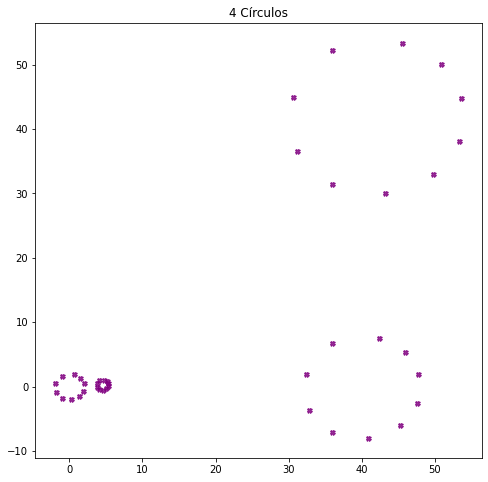

In [7]:
Circulo=np.array([[.58,1.9],[1.47,1.35],[1.94,0.47],[1.88,-0.65],[1.3,-1.5],[.21,-2],[-1,-1.77],[-1.8,-.9],[-1.9,.5],[-1,1.7]])
Circulo2=np.dot(4,(Circulo+[10,0]))
Circulo3=np.dot(0.1,(Circulo2+[5,3]))
Circulo4=np.dot(6,(Circulo+[7,7]))
Circulos=np.zeros((40,2))
Circulos[0:10]=Circulo[0:10]
Circulos[10:20]=Circulo2[0:10]
Circulos[20:30]=Circulo3[0:10]
Circulos[30:40]=Circulo4[0:10]

plt.rcParams["figure.figsize"] = (8,8)
plt.title('4 Círculos')
plt.plot(Circulos[:,0], Circulos[:,1], 'X', color='purple', alpha = 0.8, markersize=5)
plt.show()
plt.clf()
plt.cla()
plt.close()

#### Diagrama de persistencia generado por el conjunto de puntos

In [8]:
diagrama_persistencia_circulos = diagrama_nube(Circulos)
plot_diagram(diagrama_persistencia_circulos[0])

#### Paisaje de persistencia

In [9]:
PL=PersistenceLandscape(n_layers=3,n_bins=1000) # (1/n_bins)*maxima_muerte indica el tamaño del intervalo entre punto y punto, entonces entre más grande es n_bins, mejor calidad tiene la gráfica 
paisaje_persistencia_circulos=PL.fit_transform(diagrama_nube(Circulos))
PL.plot(paisaje_persistencia_circulos)

¡Enhorabuena! el diagrama de persistencia refleja claramente que hay 4 "hoyos" formados por el conjunto de puntos.

## Topología de las series de tiempo extraidas del mapa de Henon

El mapa de Henon está dado por un sistema de ecuaciones discreto

# INSERTAR LAS ECUACIONES

el cual podemos modificar

# INSERTAR LAS ECUACIONES MODIFICADAS

así entonces, podemos generar 4 series de tiempo para el parámetro x del mapa de Henon. Cada serie con un valor distinto del parámetro b (0.27,0.28,0.29,0.30). Y aplicar los métodos previamente definidos

In [10]:
def henon_attractor(x, y, a, b,i):
    
    '''
    Calcula el siguiente paso del mapa de Henon para los argumentos x, y con parámetros a y b
    
    '''
    
    x_next = 1 - a * x ** 2 + b*y + sigma*M[i]*np.sqrt(delta_t)
    y_next = x + 0.1*np.sqrt(delta_t)
    return x_next, y_next

Inicialicemos el mapa de Henon y obtengamos los primeros 1200 pasos, moviendo el parámetro a en cada paso, desde el 0 hasta 1.4 equitativamente

In [11]:
#Variable aleatoria normal
M = np.random.normal(0, 1, 100000)

In [12]:
steps = 1200
a = 0
delta_t=1/(steps/1.4)
sigma=0.3

X1 = np.zeros(steps + 1)
Y1 = np.zeros(steps + 1)

X2 = np.zeros(steps + 1)
Y2 = np.zeros(steps + 1)

X3 = np.zeros(steps + 1)
Y3 = np.zeros(steps + 1)

X4 = np.zeros(steps + 1)
Y4 = np.zeros(steps + 1)

# starting point
X1[0], Y1[0] = 1.4, 1.4

X2[0], Y2[0] = 1.4, 1.4

X3[0], Y3[0] = 1.4, 1.4

X4[0], Y4[0] = 1.4, 1.4



# Matriz de valores de a
A = np.zeros(steps+1)
for i in range (steps+1):
    A[i]=a+i*delta_t

# add points to array
for i in range(steps):
    #X1,Y1
	x_next, y_next = henon_attractor(X1[i], Y1[i],A[i],0.27,i)
	X1[i+1] = x_next
	Y1[i+1] = y_next
    #X2,Y2
	x_next, y_next = henon_attractor(X2[i], Y2[i],A[i],0.28,i)
	X2[i+1] = x_next
	Y2[i+1] = y_next
    #X3,Y3
	x_next, y_next = henon_attractor(X3[i], Y3[i],A[i],0.29,i)
	X3[i+1] = x_next
	Y3[i+1] = y_next
    #X4,Y4
	x_next, y_next = henon_attractor(X4[i], Y4[i],A[i],0.3,i)
	X4[i+1] = x_next
	Y4[i+1] = y_next

### Las gráficas 

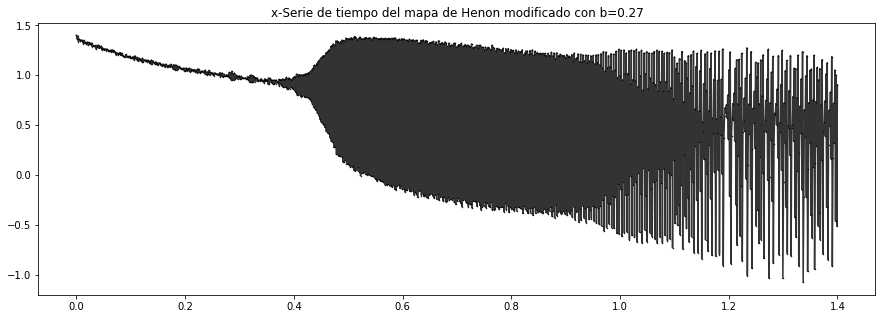

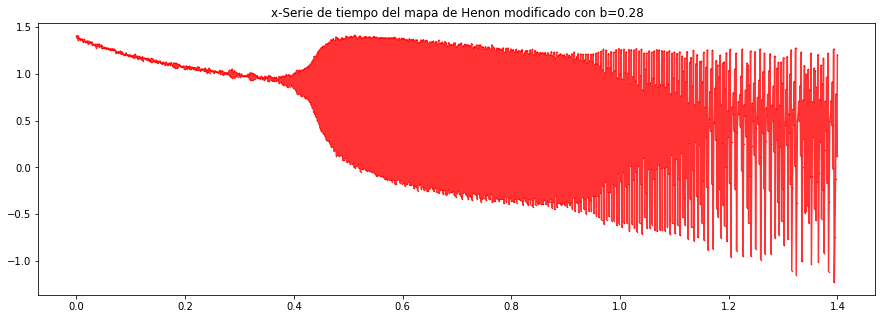

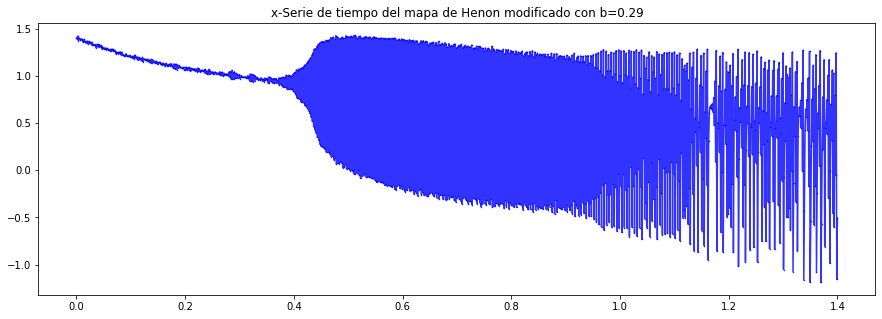

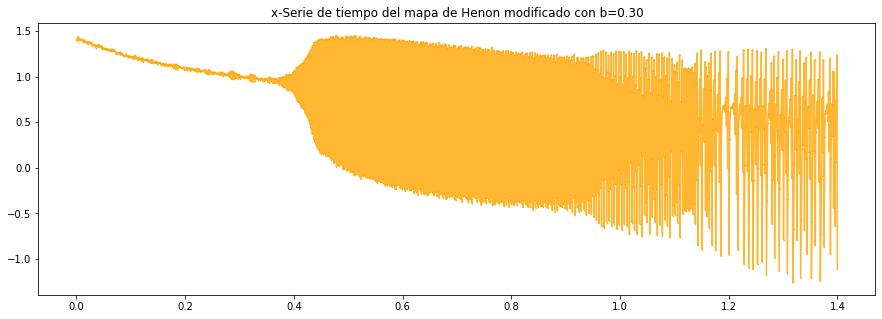

In [13]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(A, X1, '*', color='black', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('x-Serie de tiempo del mapa de Henon modificado con b=0.27')
plt.show()
plt.close()

plt.plot(A, X2, '*', color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.rcParams["figure.figsize"] = (15,5)
plt.title('x-Serie de tiempo del mapa de Henon modificado con b=0.28')
plt.show()
plt.close()

plt.plot(A, X3, '*', color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.rcParams["figure.figsize"] = (15,5)
plt.title('x-Serie de tiempo del mapa de Henon modificado con b=0.29')
plt.show()
plt.close()

plt.plot(A, X4, '*', color='orange', alpha = 0.8, markersize=1, linestyle='solid')
plt.rcParams["figure.figsize"] = (15,5)
plt.title('x-Serie de tiempo del mapa de Henon modificado con b=0.30')
plt.show()
plt.close()

### Obtención de la información topológica

In [14]:
Henon1=X1
Henon2=X2
Henon3=X3
Henon4=X4


window_sz = 50
dimension = 4
numero_pasos = Henon1.size - window_sz + 1

#obtener una serie de tiempo de las 1-normas de las ventanas de la serie de tiempo definida por el mapa de Henon
normas1_Henon=[]
normas2_Henon=[]

for i in range (numero_pasos):
    if (i%50==0):
        print(str(i)+ " de " + str(numero_pasos))

    nube_puntos_ventana = PointCloud(Henon1,Henon2,Henon3,Henon4,i,window_sz)
    
    diagrama_ventana = diagrama_nube(nube_puntos_ventana)
    maxima_muerte_ventana = maxima_muerte(diagrama_ventana)
    
    paisaje_ventana = paisaje_persistencia_de_diagrama(diagrama_ventana,10,500)
    
    norma1_ventana = norma1PL(paisaje_ventana,maxima_muerte_ventana)
    norma2_ventana = norma2PL(paisaje_ventana,maxima_muerte_ventana)
    
    normas1_Henon.append(norma1_ventana)
    normas2_Henon.append(norma2_ventana)
    
normas1_Henon = np.array(normas1_Henon)
normas2_Henon = np.array(normas2_Henon)

0 de 1152
50 de 1152
100 de 1152
150 de 1152
200 de 1152
250 de 1152
300 de 1152
350 de 1152
400 de 1152
450 de 1152
500 de 1152
550 de 1152
600 de 1152
650 de 1152
700 de 1152
750 de 1152
800 de 1152
850 de 1152
900 de 1152
950 de 1152
1000 de 1152
1050 de 1152
1100 de 1152
1150 de 1152


Procedamos a la normalización de los datos.

Se normaliza con respecto del mín-max.

In [15]:
normas1_Henon_normal2 = normalize(normas1_Henon,0,1)
normas2_Henon_normal2 = normalize(normas2_Henon,0,1)

### Gráfica de la serie de tiempo de las normas de las ventanas de las x-series de tiempo del mapa de Henon

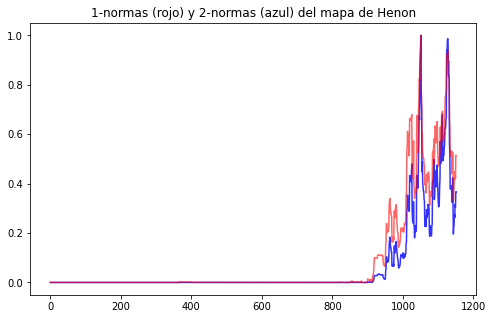

In [16]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(normas1_Henon_normal2, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.plot(normas2_Henon_normal2, color='red', alpha = 0.6, markersize=1, linestyle='solid')
plt.title('1-normas (rojo) y 2-normas (azul) del mapa de Henon')
plt.show()
plt.close()

Como podemos observar, cuando estamos en el aproximadamente en el paso 900 (es decir a=1 aprox), las normas empiezan a tener aumento, prediciendo así que el mapa de Henon está por volverse caótico.

Observemos una como luce el paisaje de persistencia de una de las ventanas en los momentos caóticos

In [17]:
PL.plot(paisaje_ventana)

# Topología de las series de tiempo de los índices bursátiles

Ahora sí, enfrentémonos al problema por el cual venimos. Encontrar señales de peligro tempranas para los colapsos financieros

### Obtención de los datos.

In [18]:
import yfinance as yf

In [19]:
dataSP500=yf.download('^GSPC', start='1992-12-23', end='2016-12-08')
dataDJIA=yf.download('^DJI', start='1992-12-23', end='2016-12-08')
dataNASDAQ=yf.download('^IXIC', start='1992-12-23', end='2016-12-08')
dataRussell2000=yf.download('^RUT', start='1992-12-23', end='2016-12-08')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Limpieza de los datos.

No consideraremos las series de tiempo por sí solas, sino que utilizaremos la popular sistema de análisis financiero, el log-return 

In [20]:
dataSP500close = dataSP500["Close"]
logreturnSP500 = np.log(dataSP500close.pct_change()+1)
logreturnSP500 = logreturnSP500.to_numpy()
logreturnSP500[0]=logreturnSP500[1]

dataDJIAclose = dataDJIA["Close"]
logreturnDJIA = np.log(dataDJIAclose.pct_change()+1)
logreturnDJIA = logreturnDJIA.to_numpy()
logreturnDJIA[0]=logreturnDJIA[1]

dataNASDAQclose = dataNASDAQ["Close"]
logreturnNASDAQ = np.log(dataNASDAQclose.pct_change()+1)
logreturnNASDAQ = logreturnNASDAQ.to_numpy()
logreturnNASDAQ[0]=logreturnNASDAQ[1]

dataRussell2000close = dataRussell2000["Close"]
logreturnRussell2000 = np.log(dataRussell2000close.pct_change()+1)
logreturnRussell2000 = logreturnRussell2000.to_numpy()
logreturnRussell2000[0]=logreturnRussell2000[1]

### Normalización de los datos del precio del NASDAQ.
Esto es para poder comparar en el mismo gráfico las normas que obtendremos y el precio de uno de los índices

In [21]:
n2000=dataNASDAQ.drop(axis=1,labels=["Open","High","Low","Adj Close","Volume"]).loc["1996-01-26":"2000-12-11"]
n2000np=n2000["Close"].to_numpy()
n2000np=np.reshape(n2000np,n2000np.shape[0])
n2000np=np.array(normalize(n2000np,0,1))
n2000.insert(1,"Precio",n2000np,allow_duplicates=False)
n2000=n2000.drop('Close', axis=1)


n2008=dataNASDAQ.drop(axis=1,labels=["Open","High","Low","Adj Close","Volume"]).loc["2004-06-29":"2008-12-17"]
n2008np=n2008["Close"].to_numpy()
n2008np=np.reshape(n2008np,n2008np.shape[0])
n2008np=np.array(normalize(n2008np,0,1))
n2008.insert(1,"Precio",n2008np,allow_duplicates=False)
n2008=n2008.drop('Close', axis=1)

### Mismo proceso de la topología del mapa de Henon
#### Series de tiempo ---> Nubes de puntos ---> Diagramas de Persistencia ---> Paisajes de Persistencia ---> normas LP

In [22]:
ts1=logreturnSP500
ts2=logreturnDJIA
ts3=logreturnNASDAQ
ts4=logreturnRussell2000


window_szF = 50
numero_pasosF = ts1.size - window_szF + 1

normas1_Stocks=[]
normas2_Stocks=[]

for j in range (numero_pasosF):
    if (j%200==0):
        print(str(j)+ " de " + str(numero_pasosF))

    nube_puntos_ventanaF = PointCloud(ts1,ts2,ts3,ts4,j,window_szF)
    
    diagrama_ventanaF = diagrama_nube(nube_puntos_ventanaF)
    maxima_muerte_ventanaF = maxima_muerte(diagrama_ventanaF)
    
    paisaje_ventanaF = paisaje_persistencia_de_diagrama(diagrama_ventanaF,10,500)
    
    norma1_ventanaF = norma1PL(paisaje_ventanaF,maxima_muerte_ventanaF)
    
    normas1_Stocks.append(norma1_ventanaF)

normas1_Stocks = np.array(normas1_Stocks)

0 de 5986
200 de 5986
400 de 5986
600 de 5986
800 de 5986
1000 de 5986
1200 de 5986
1400 de 5986
1600 de 5986
1800 de 5986
2000 de 5986
2200 de 5986
2400 de 5986
2600 de 5986
2800 de 5986
3000 de 5986
3200 de 5986
3400 de 5986
3600 de 5986
3800 de 5986
4000 de 5986
4200 de 5986
4400 de 5986
4600 de 5986
4800 de 5986
5000 de 5986
5200 de 5986
5400 de 5986
5600 de 5986
5800 de 5986


### Normalización de los datos (con respecto del mín-max).

In [24]:
normas1_Stocks_normal2 = normalize(normas1_Stocks,0,1)

### Agregamos el formato a los datos.

In [25]:
dfnormas=pd.DataFrame(normas1_Stocks_normal2,columns=["norma"])
new_index = dataSP500.iloc[0:numero_pasosF].index
dfnormas["Date"]=new_index
dfnormas=dfnormas.set_index("Date")

### Regresamos mil registros antes de la cercanía del colapso

In [26]:
df2000=dfnormas.loc["1996-01-26":"2000-12-11"]
df2008=dfnormas.loc["2004-06-29":"2008-12-17"]

### Normalización

In [27]:
df2000np=df2000["norma"].to_numpy()
df2000np=np.reshape(df2000np,df2000np.shape[0])
df2000np=np.array(normalize(df2000np,0,1))
df2000.insert(1,"normal",df2000np,allow_duplicates=False)
df2000=df2000.drop('norma', axis=1)

df2008np=df2008["norma"].to_numpy()
df2008np=np.reshape(df2008np,df2008np.shape[0])
df2008np=np.array(normalize(df2008np,0,1))
df2008.insert(1,"normal",df2008np,allow_duplicates=False)
df2008=df2008.drop('norma', axis=1)

### Gráficas.

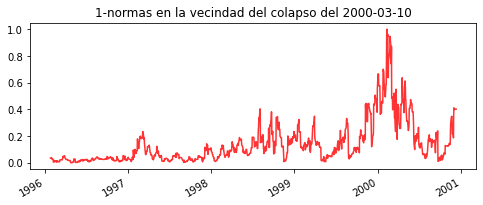

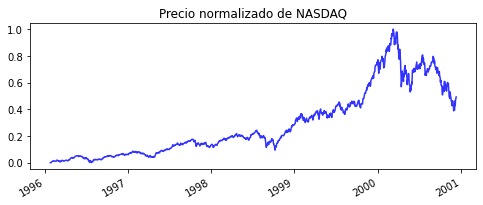

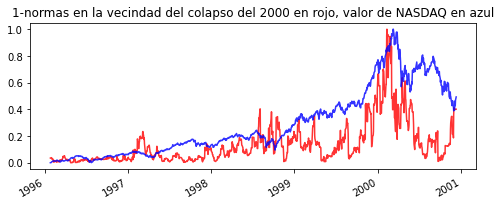

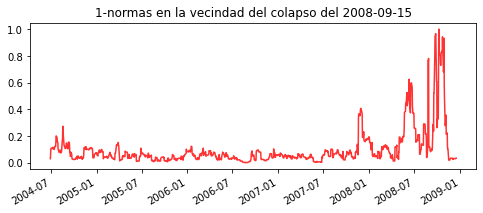

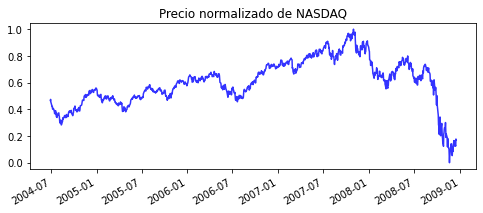

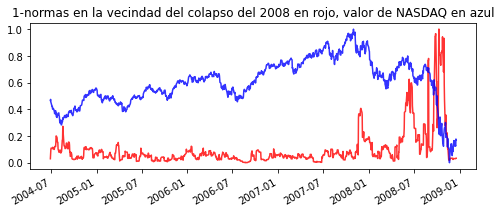

In [28]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(df2000, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('1-normas en la vecindad del colapso del 2000-03-10')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()


plt.rcParams["figure.figsize"] = (8,3)
plt.plot(n2000, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('Precio normalizado de NASDAQ')
plt.gcf().autofmt_xdate()
plt.savefig('1-normas-2008.png', dpi=300)
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(df2000, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.plot(n2000, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('1-normas en la vecindad del colapso del 2000 en rojo, valor de NASDAQ en azul')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(df2008, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('1-normas en la vecindad del colapso del 2008-09-15')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(n2008, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('Precio normalizado de NASDAQ')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(df2008, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.plot(n2008, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.title('1-normas en la vecindad del colapso del 2008 en rojo, valor de NASDAQ en azul')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

Como podemos observar, después de que se presentan crecimientos pronunciados de las normas LP (en esta caso P=1) hay una considerable caída de los índices, indicador claro de un colapso económico

## Ejemplo extra: Criptomonedas

Para este ejemplo nos basaremos en las criptomoedas más comerciales de los últimos tiempos:

* BTC $\leftarrow$ Bitcoin
* ETH $\leftarrow$ Etherium
* XRP $\leftarrow$ Ripple
* ADA $\leftarrow$ Cardano

### Lectura de datos.

In [29]:
dataBTC = pd.read_csv('dataBTC.csv', index_col='Date')
dataETH = pd.read_csv('dataETH.csv', index_col='Date')
dataXRP = pd.read_csv('dataXRP.csv', index_col='Date')
dataADA = pd.read_csv('dataADA.csv', index_col='Date')

### Normalización del precio del Bitcoin.

In [30]:
btcN=dataBTC.drop(axis=1,labels=["Open","High","Low","Volume"])
btcNnp=btcN["close"].to_numpy()
btcNnp=np.reshape(btcNnp,btcNnp.shape[0])
btcNnp=np.array(normalize(btcNnp,0,1))
btcN.insert(1,"Precio",btcNnp,allow_duplicates=False)
btcN=btcN.drop('close', axis=1)
btcN.index = pd.to_datetime(btcN.index)

### Limpieza de datos.

In [31]:
dataBTCclose = dataBTC["close"]
dataBTCclose.index = pd.to_datetime(dataBTCclose.index)
logreturnBTC = np.log(dataBTCclose.pct_change()+1)
logreturnBTC = logreturnBTC.to_numpy()
logreturnBTC[0]=logreturnBTC[1]

dataETHclose = dataETH["close"]
logreturnETH = np.log(dataETHclose.pct_change()+1)
logreturnETH = logreturnETH.to_numpy()
logreturnETH[0]=logreturnETH[1]

dataXRPclose = dataXRP["close"]
logreturnXRP = np.log(dataXRPclose.pct_change()+1)
logreturnXRP = logreturnXRP.to_numpy()
logreturnXRP[0]=logreturnXRP[1]

dataADAclose = dataADA["close"]
logreturnADA = np.log(dataADAclose.pct_change()+1)
logreturnADA = logreturnADA.to_numpy()
logreturnADA[0]=logreturnADA[1]

### Cálculo topológico (análogo a los anteriores)

In [32]:
cts1=logreturnBTC
cts2=logreturnETH
cts3=logreturnXRP
cts4=logreturnADA


window_szF = 50
numero_pasosc = cts1.size - window_szF + 1

normas1_cStocks=[]
normas2_cStocks=[]

for j in range (numero_pasosc):
    if (j%100==0):
        print(str(j)+ " de " + str(numero_pasosc))

    nube_puntos_ventanaF = PointCloud(cts1,cts2,cts3,cts4,j,window_szF)
    
    diagrama_ventanaF = diagrama_nube(nube_puntos_ventanaF)
    maxima_muerte_ventanaF = maxima_muerte(diagrama_ventanaF)
    
    paisaje_ventanaF = paisaje_persistencia_de_diagrama(diagrama_ventanaF,10,500)
    
    norma1_ventanaF = norma1PL(paisaje_ventanaF,maxima_muerte_ventanaF)
    norma2_ventanaF = norma2PL(paisaje_ventanaF,maxima_muerte_ventanaF)
    
    normas1_cStocks.append(norma1_ventanaF)
    normas2_cStocks.append(norma2_ventanaF)
    
normas1_cStocks = np.array(normas1_cStocks)
normas2_cStocks = np.array(normas2_cStocks)

#normalizo los datos
normas1_cStocks_normal2 = normalize(normas1_cStocks,0,1)
normas2_cStocks_normal2 = normalize(normas2_cStocks,0,1)

0 de 1151
100 de 1151
200 de 1151
300 de 1151
400 de 1151
500 de 1151
600 de 1151
700 de 1151
800 de 1151
900 de 1151
1000 de 1151
1100 de 1151


### Añadimos formato

In [33]:
dfcnormas=pd.DataFrame(normas2_cStocks_normal2,columns=["norma"])
cnew_index = dataBTC.iloc[0:numero_pasosc].index
dfcnormas["Date"]=cnew_index
dfcnormas=dfcnormas.set_index("Date")
dfcnormas.index = pd.to_datetime(dfcnormas.index)

### Gráficas

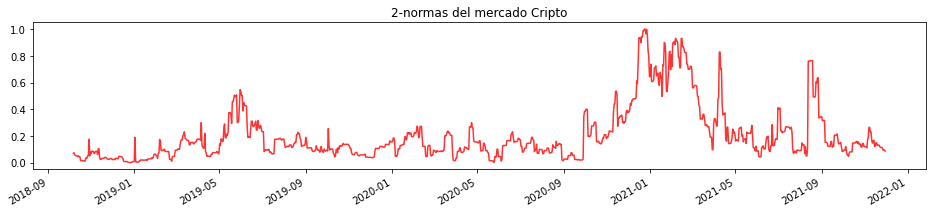

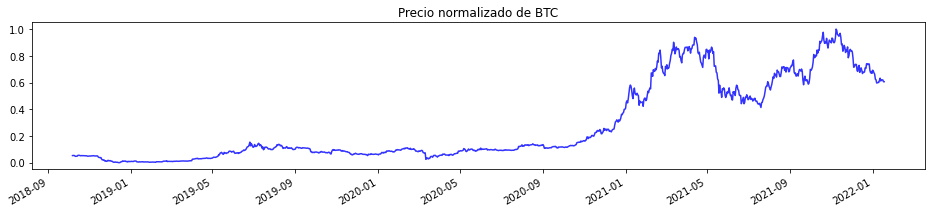

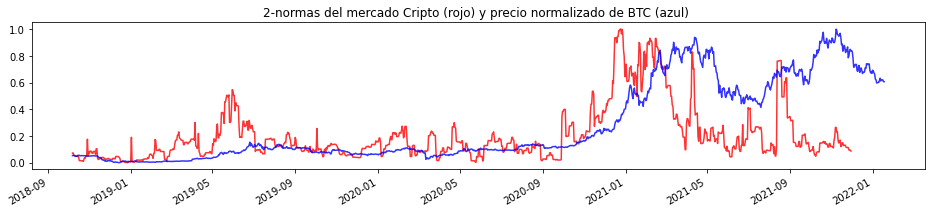

In [34]:
plt.rcParams["figure.figsize"] = (16,3)
plt.plot(dfcnormas, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('2-normas del mercado Cripto')
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (16,3)
plt.plot(btcN, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Precio normalizado de BTC')
plt.show()
plt.close()

plt.rcParams["figure.figsize"] = (16,3)
plt.plot(dfcnormas, color='red', alpha = 0.8, markersize=1, linestyle='solid')
plt.plot(btcN, color='blue', alpha = 0.8, markersize=1, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('2-normas del mercado Cripto (rojo) y precio normalizado de BTC (azul) ')
plt.show()
plt.close()

Podemos Observar que incluso en mercados tan volátiles como el de las criptomonedas, los resultados son los mismos.

### Función de autocorrelación

En la práctica, la función de **autocorrelación** sirve para medir qué tanta influencia tienen los datos pasados en los nuevos, dicho de otra manera, qué tanto influyen los valores observados anteriormente con los nuevos.

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

#### función de autocorrelación para la serie de tiempo de las 1-normas de Henon

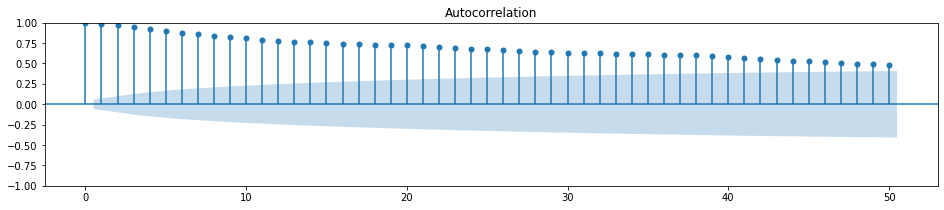

In [36]:
plot_acf(x=normas1_Henon, lags=50, alpha=0.05)

plt.show()

Cómo se puede notar en la gráfica anterior, los datos observados aún tiene cierta significancia, todos los valores previos quedan fuera del intervalo de confianza, es decir, al agregar los datos que se encuentran fuera de la región en azul podemos asegurar que nos agregan significancia a nuestras observaciones.

#### función de autocorrelación para la serie de tiempo de las 2-normas de Henon

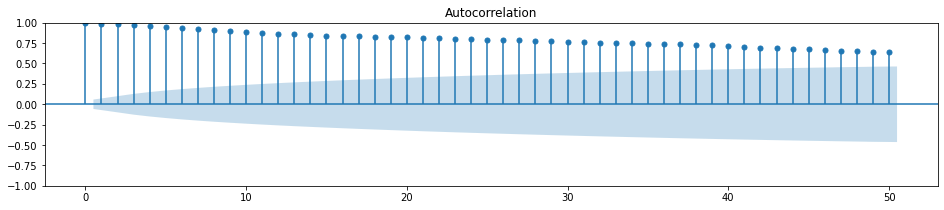

In [37]:
plot_acf(x=normas2_Henon, lags=50, alpha=0.05)

plt.show()

In [38]:
#### función de autocorrelación para la serie de tiempo de las 1-normas de las criptomonedas

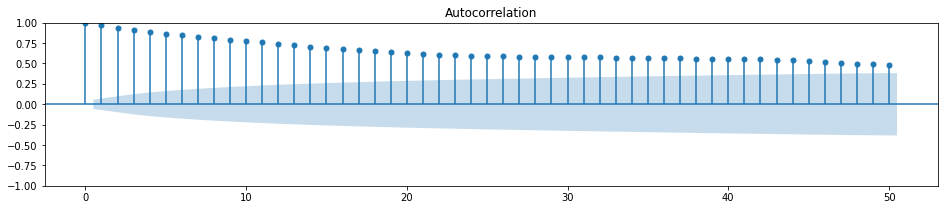

In [39]:
plot_acf(x=normas2_cStocks, lags=50, alpha=0.05)

plt.show()

In [40]:
#### función de autocorrelación para la serie de tiempo de las 2-normas de las criptomonedas

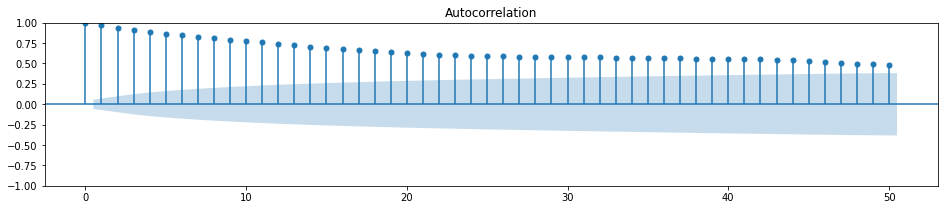

In [41]:
plot_acf(x=normas2_cStocks, lags=50, alpha=0.05)

plt.show()

# Conclusión

El objetivo de este proyecto era demostrar que las series de tiempo formadas por las normas de los paisajes de persistencia pueden ser usadas como señales tempranas de alarma de colapsos financieros, lo cual concluimos cierto gracias al análisis de las series de tiempo de las normas $ L^P $, ya que estas muestran un rápido crecimiento previo a un colapso.Además, comprobamos que el análisis topológico de datos es muy útil para extraer características de la base datos.